In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, UpSampling2D, Conv2D, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from pathlib import Path

In [ ]:
path = '/content/drive/MyDrive/Deep/data/'
img_size = 256

tr = pd.read_csv(path + 'train.csv')
print("Number of cloud formations: {}".format(len(tr)))
tr.head()

img_names_all = tr['Image_Label'].apply(lambda x: x.split('_')[0]).unique()
print("Number of images: " + str(len(img_names_all)))

Number of cloud formations: 22184
Number of images: 5546


In [ ]:
def rle2mask(rle, cloud_type, mask):
    array = np.asarray([int(x) for x in rle.split()])
    s = array[0::2]
    l = array[1::2]
    for i, start in enumerate(s):
        mask_val = cloud_type / 4.0 * 255
        mask[int(start):int(start+l[i])] = mask_val
    return mask

In [ ]:
def dice_loss(y_true, y_pred):
    return 1. - (2. * K.sum(K.flatten(y_true) * K.flatten(y_pred)) + 1.) / (K.sum(K.flatten(y_true)) + K.sum(K.flatten(y_pred)) + 1.)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
gen_masks = False
dPath = path + 'dataset/'
if gen_masks:
  # Prepare directory structure
  dPath = path + 'dataset/'
  Path(dPath + 'train/imgs/img').mkdir(parents=True, exist_ok=True)
  Path(dPath + 'train/masks/img').mkdir(parents=True, exist_ok=True)
  Path(dPath + 'val/imgs/img').mkdir(parents=True, exist_ok=True)
  Path(dPath + 'val/masks/img').mkdir(parents=True, exist_ok=True)

  valSplit = 0.9

  # Cloud types reference
  cloudTypesDict = {'Fish': 1, 'Flower': 2, 'Gravel': 3, 'Sugar': 4}

  # Create masks subfolder
  masks = []
  for i, row in tr.iterrows():

      # Cloud data
      img_data = row['Image_Label'].split('_')
      cloud_name = img_data[0]
      cloud_type = cloudTypesDict[img_data[1]]
      rle = row['EncodedPixels']

      # Load image
      img = cv2.imread(path + 'train_images/'+ cloud_name)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # Reset mask
      if i % 4 == 0:
        last_mask = np.zeros(img.shape[0] * img.shape[1]).astype(np.uint8)

      if pd.isnull(rle):
          mask = last_mask
      else:
          mask = rle2mask(rle, cloud_type, last_mask)
      last_mask = mask
          
      if i % 4 == 3 and i > 0:
        mask = np.flipud( np.rot90( mask.reshape(img.shape[1], img.shape[0]), k=1 ) )
        mask = cv2.resize(mask, (img_size, img_size))
        cv2.imwrite(dPath + ('train/masks/img/' if i < round(len(tr) * valSplit) else 'val/masks/img/') + cloud_name, mask)
        cv2.imwrite(dPath + ('train/imgs/img/' if i < round(len(tr) * valSplit) else 'val/imgs/img/') + cloud_name, img)
        print('[{}%] Saved {}'.format(round((i / len(tr)) * 100, 2), cloud_name))

In [ ]:
# Instantiate data generators (train & validation)

batch_size = 16

data_generator = ImageDataGenerator(rescale=1./255)

train_img_generator = data_generator.flow_from_directory(directory=dPath + 'train/imgs', target_size=(img_size, img_size), color_mode='rgb', batch_size=batch_size, class_mode=None, classes=None)
train_mask_generator = data_generator.flow_from_directory(directory=dPath + 'train/masks', target_size=(img_size, img_size), color_mode='grayscale', batch_size=batch_size, class_mode=None, classes=None)
train_generator = zip(train_img_generator, train_mask_generator)

val_img_generator = data_generator.flow_from_directory(directory=dPath + 'val/imgs', target_size=(img_size, img_size), color_mode='rgb', batch_size=batch_size, class_mode=None, classes=None)
val_mask_generator = data_generator.flow_from_directory(directory=dPath + 'val/masks', target_size=(img_size, img_size), color_mode='grayscale', batch_size=batch_size, class_mode=None, classes=None)
val_generator = zip(val_img_generator, val_mask_generator)

Found 4991 images belonging to 1 classes.
Found 4991 images belonging to 1 classes.
Found 555 images belonging to 1 classes.
Found 555 images belonging to 1 classes.


In [ ]:
def contracting_block(x, s):
    
    conv = Conv2D(s, 3, activation = 'relu', padding = 'same')(x)
    conv = Conv2D(s, 3, activation = 'relu', padding = 'same')(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
   
    return conv, pool

def expanding_block(x, c, s):
    
    us = UpSampling2D(size = (2,2))(x)
    up = Conv2D(s, 2, activation = 'relu', padding = 'same')(us)
    merge = concatenate([c, up], axis = 3)
    x = Conv2D(s, 3, activation = 'relu', padding = 'same')(merge)
    x = Conv2D(s, 3, activation = 'relu', padding = 'same')(x)

    return x

def gen_model(input_size, filter_s = [64, 128, 256, 512]):

    # Input 
    inputs = Input((input_size, input_size, 3))
    x = inputs

    # Contracting blocks
    convs = []
    for s in filter_s:
      conv, x = contracting_block(x,s)
      convs.append(conv)    # Store convolution layers for horizontal concatenation (copy and crop)

    # Middle convolution layers
    x = Conv2D(filter_s[-1] * 2, 3, activation = 'relu', padding = 'same')(x)
    x = Conv2D(filter_s[-1] * 2, 3, activation = 'relu', padding = 'same')(x)

    # Expanding blocks
    filter_s.reverse()
    for s in filter_s:
      x = expanding_block(x, convs.pop(-1), s)

    # Last blocks
    x = Conv2D(2, 3, activation = 'relu', padding = 'same')(x)
    x = Conv2D(1, 1, activation = 'sigmoid')(x)   # Sigmoid used as mask values are [0, 1]

    model = Model(inputs = inputs, outputs = x)
    model.summary()

    return model


In [ ]:
model = gen_model(img_size)
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = bce_dice_loss)


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 256, 256, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_120[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_121[0][0]                 
____________________________________________________________________________________________

In [ ]:
%%time
train = False
checkpoint_filepath = '/content/drive/MyDrive/Deep/Models/Mymodel_1mask/best_model_val_loss.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

if train:
  model.fit_generator(train_generator, epochs=100, validation_data=val_generator, steps_per_epoch=4991//batch_size, validation_steps = 555//batch_size, callbacks=[model_checkpoint_callback])
  model.save('/content/drive/MyDrive/Deep/Models/Mymodel_1mask/my_model_loss.h5')
else:
  model.load_weights('/content/drive/MyDrive/Deep/Models/Mymodel_1mask/best_model_val_loss.h5')

CPU times: user 67.2 ms, sys: 77.5 ms, total: 145 ms
Wall time: 220 ms


In [ ]:
testfilename = 'e6388bb.jpg'
testfile = path + 'dataset/val/imgs/img/' + testfilename  
testmask = path + 'dataset/val/masks/img/' + testfilename

img = cv2.imread(testfile)
img = cv2.resize(img,(img_size,img_size))       
predict = model.predict(np.resize(np.asarray(img),(1,img_size,img_size,3)))

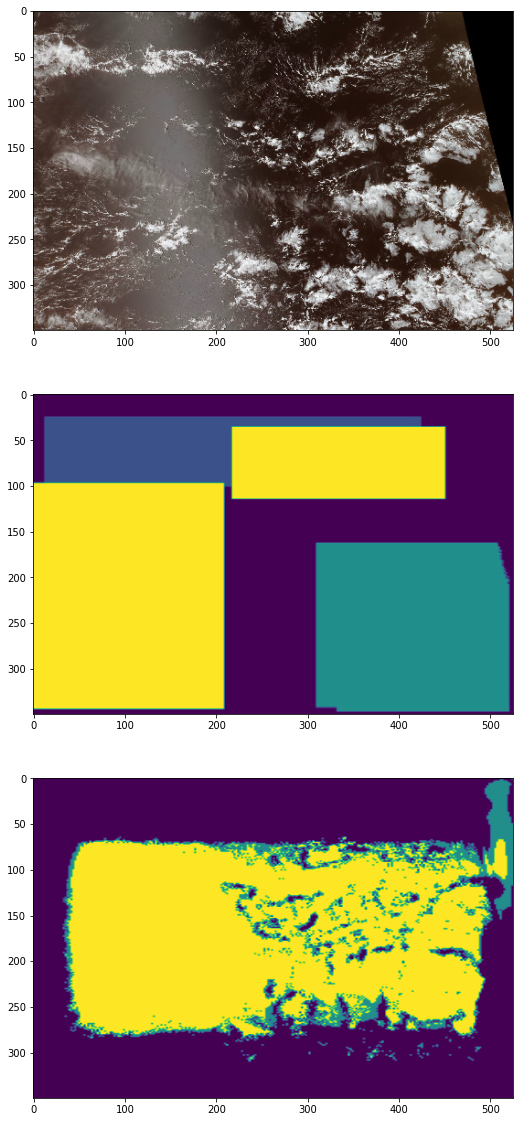

In [ ]:
fig, axs = plt.subplots(3, figsize=(20, 20))
axs[0].imshow(cv2.resize(plt.imread(testfile),(525, 350)))
axs[1].imshow(cv2.resize(plt.imread(testmask),(525, 350)))

th = [32, 96, 160, 224]
th_dest = [0, 63, 127, 191, 255]
pred_img = predict*255

for i in range(pred_img.shape[1]):
  for j in range(pred_img.shape[2]):
    for k in range(len(th)):
      if pred_img[0,i,j,0] <= th[k]:
        pred_img[0,i,j,0] = th_dest[k]
        break
      elif pred_img[0,i,j,0] > th[-1]:
        pred_img[0,i,j,0] = th_dest[-1]
        break

cv2.imwrite('pred.png', pred_img[0])
axs[2].imshow(cv2.resize(plt.imread('pred.png'),(525, 350)))
